In [2]:
import os
import re
import cv2
import math

import numpy as np
import matplotlib.pyplot as plt

# generate
from imutils import rotate_bound
from random import randint, shuffle

# files
import utils
# import dataset 

In [20]:
# Load the dataset

train_data_path= "../../data/imgs/artificial/"
circle_img_paths=[]
blob_img_paths=[]
# shard_img_paths=[]
fibers_img_paths=[]
all_img_paths=[]
for root, dirs, files in os.walk(train_data_path, topdown=False):
    for name in files:
        if re.findall('.jpg', name):  
            imgPath = os.path.join(root,name)
            if re.findall('fibers', imgPath):
                fibers_img_paths.append(imgPath) 
            elif re.findall('blobs', imgPath):
                blob_img_paths.append(imgPath)        
            elif re.findall('circles', imgPath):
                circle_img_paths.append(imgPath)    
all_img_paths.append(fibers_img_paths) 
all_img_paths.append(blob_img_paths) 
all_img_paths.append(circle_img_paths)
if not all_img_paths:
    print("err loading ",train_data_path)
else:
    print("circles ",len(circle_img_paths))    
    print("blobs ",len(blob_img_paths))    
    print("fibers ",len(fibers_img_paths))

circles  843
blobs  41
fibers  130


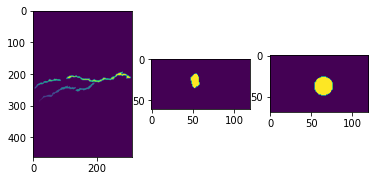

(462, 311, 3)


In [21]:
fig, axarr = plt.subplots(1,3)

for idx, classList in enumerate(all_img_paths):
    image = cv2.imread(classList[0])
    imageMask = utils.getMask(image,threshold=100,kernelSize=5) 
    # listContours = markContours(imageMask) 
    imgContours = utils.img2segmented(imageMask)
    
    axarr[idx].imshow(imgContours)
    
plt.show()
#     a=np.unique(imgContours)
print(cv2.imread(fibers_img_paths[0]).shape)

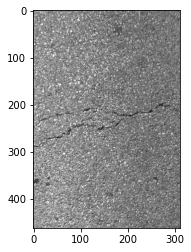

2 (2, 5) (2, 2)


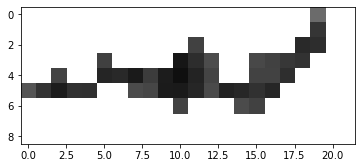

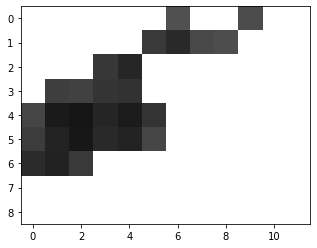

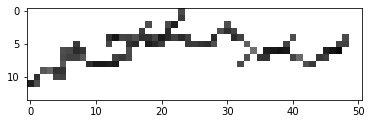

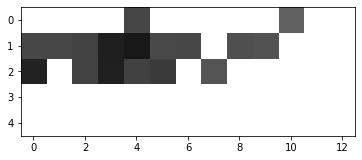

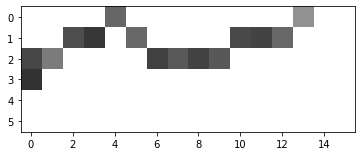

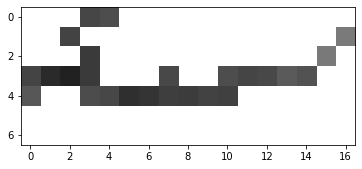

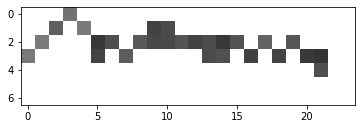

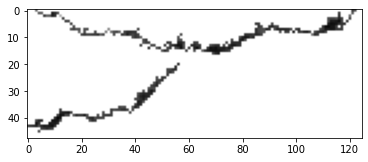

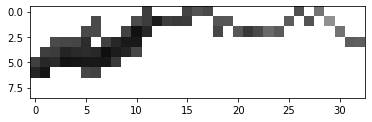

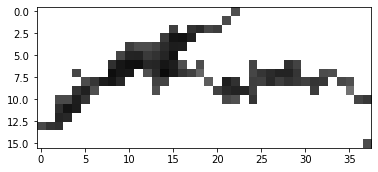

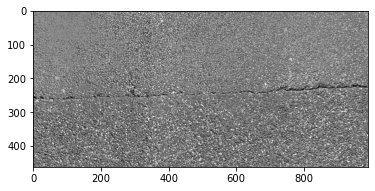

2 (2, 5) (2, 2)


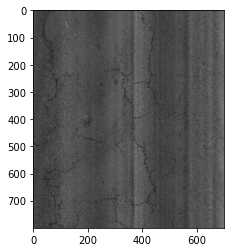

4 (4, 5) (4, 2)


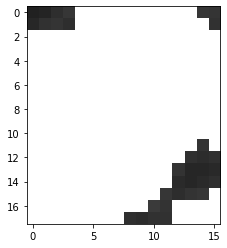

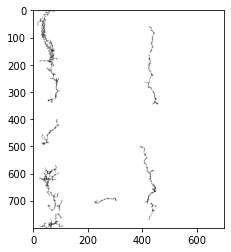

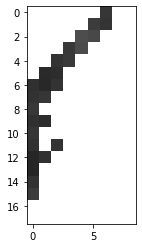

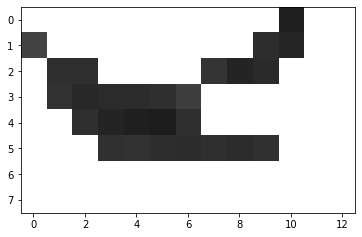

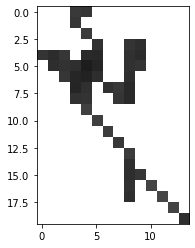

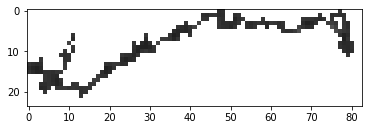

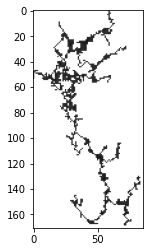

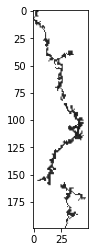

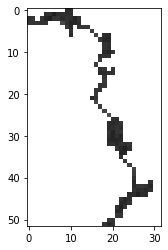

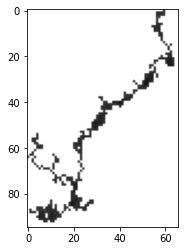

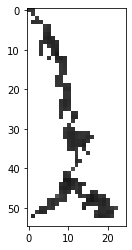

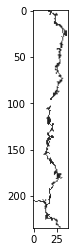

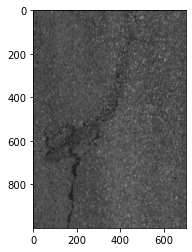

4 (4, 5) (4, 2)


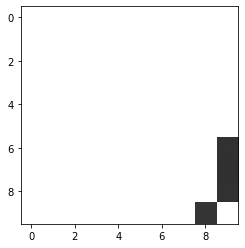

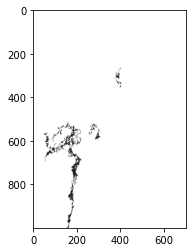

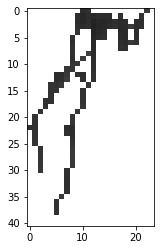

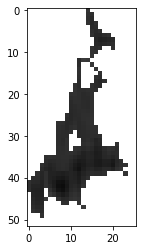

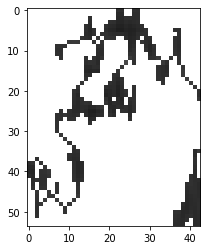

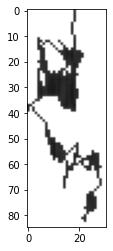

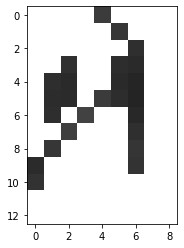

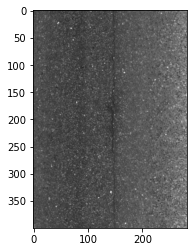

2 (2, 5) (2, 2)


error: OpenCV(4.7.0) /io/opencv/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


In [27]:
for imgPath in fibers_img_paths:
    crackPth= os.path.join(os.path.dirname(imgPath),"IMAGES")
    base= os.path.basename(imgPath)
    base = re.split("Res_", base)[-1]
    base = "Im_"+base[:-3]+"png"
    crackPth= os.path.join(crackPth, base)
    imageOrig = cv2.imread(crackPth)
    
    plt.imshow(imageOrig)
    plt.show()
    
    image = cv2.imread(imgPath)
    imageMask = utils.getMask(image,threshold=100,kernelSize=10) 
    contours = cv2.findContours(imageMask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # img, contours, hierarchy

    labelsCount, _, values, centroids=  cv2.connectedComponentsWithStats(imageMask) 
    print(labelsCount, values.shape, centroids.shape)

    contoursImg = np.zeros(image.shape, dtype=np.uint8)
    axSize = math.sqrt(labelsCount)

    for i,cnt in enumerate(contours[0]): # iterate through contours
        if i > 0 and cv2.contourArea(cnt.squeeze())>30:  # skip background
#             if cv2.contourArea(contour)<9:
            contour = cnt.squeeze()
            xmin,ymin,w,h = cv2.boundingRect(contour)  #  xmin(left),ymin(top),w,h
            cutoutOrig = imageOrig[ymin:ymin+h,xmin:xmin+w]	# 
            cutoutMask = image[ymin:ymin+h,xmin:xmin+w]
            cutout = cv2.bitwise_or(cutoutOrig,cutoutMask)
#             cutout = imageMask[ymin:ymin+h,xmin:xmin+w]
            
            plt.imshow(cutout)
            plt.show()
#         axarr[idx].imshow(imgContours)

# plt.show()
            # cv2.rectangle(contoursImg,(BBox[0],BBox[1]),(BBox[0]+BBox[2],BBox[1]+BBox[3]),(0,255,0),2)
        

In [ ]:

	datasets=[]
	for root, dirs, files in os.walk(train_data_path):
		for i,name in enumerate(files):
		    if re.findall('.csv', name):
		        # print(i,' ',name)
		        data_arr=np.loadtxt(os.path.join(root, name), delimiter=',')
		        data_arr=data_normalize(data_arr) 

		        dataset= create_dataset(data_arr,i, name)
	#             print(dataset.data.shape)
		        datasets.append(dataset)
		break   #prevent descending into subfolders

	dataset=Dataset()
	for ds in datasets:
		dataset.add_items(ds.data, ds.labels)
		for key in ds.classes:
			dataset.add_class(key, ds.classes[key])
	return dataset

2 (2, 5) (2, 2)


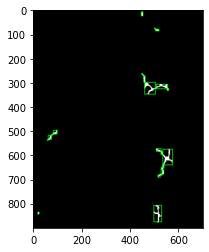

In [82]:
image = cv2.imread(all_img_paths[0][0])
imageMask = utils.getMask(image,threshold=100,kernelSize=10) 
contours = cv2.findContours(imageMask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # img, contours, hierarchy

labelsCount, _, values, centroids=  cv2.connectedComponentsWithStats(imageMask) 
print(labelsCount, values.shape, centroids.shape)

contoursImg = np.zeros(image.shape, dtype=np.uint8)
axSize = math.sqrt(labelsCount)
fig, axarr = plt.subplots(1,3)

for i,cnt in enumerate(contours[0]): # iterate through contours
    if i > 0:  # skip background
        contour = cnt.squeeze()
        """ coco features """
#         image0 = np.zeros(image.shape, dtype=np.uint8)

        moments = cv2.moments(contour)
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
        
        BBox = cv2.boundingRect(contour)  # cv2.rectangle(contoursImg,(BBox[0],BBox[1]),(BBox[0]+BBox[2],BBox[1]+BBox[3]),(0,255,0),2)
        area = cv2.contourArea(contour)
        
        cv2.rectangle(contoursImg,(BBox[0],BBox[1]),(BBox[0]+BBox[2],BBox[1]+BBox[3]),(0,255,0),2)
        contoursImg = cv2.drawContours(contoursImg, contours[0],i,(255,255,255), thickness=cv2.FILLED)


plt.imshow(contoursImg)
plt.show()
    

# plot_intensity_histogram(image) 

In [ ]:
#@title generate_image() code
!pip install imutils
import numpy as np

from imutils import rotate_bound
from math import ceil
from random import randint, shuffle

def generate_image(particle_examples, img_config):
#############################################################################
    img_fuse = cv2.imread("fuse.png")
    img_fuse = cv2.cvtColor(img_fuse, cv2.COLOR_BGR2RGB)
    img_damaged_fuse = cv2.imread("damaged_fuse.png")
    img_damaged_fuse = cv2.cvtColor(img_damaged_fuse, cv2.COLOR_BGR2RGB)

    shape = img_fuse.shape
    radius = ceil((shape[0]**2 + shape[1]**2)**0.5)

    num_cols = ceil(number_of_fuses**0.5)

    generated_image = 255*np.ones((num_cols*radius, num_cols*radius, 3), dtype=np.uint8)
    number_of_damaged_fuses = randint(0, number_of_fuses)

    class_labels = [i < number_of_damaged_fuses for i in range(number_of_fuses)]
    shuffle(class_labels)

    for i in range(number_of_fuses):
        row = i // num_cols
        col = i % num_cols

        angle = randint(0, 359)

        original_image = np.copy(img_damaged_fuse) if class_labels[i] else np.copy(img_fuse)
        rotated_image = rotate_bound(255 - original_image, angle)
        final_image = 255*np.ones((radius, radius, 3), dtype=np.uint8)
        ri_rows, ri_cols, _ = rotated_image.shape
        final_image[:ri_rows, :ri_cols, :] = 255 -rotated_image

        generated_image[row*radius:(row+1)*radius, col*radius:(col+1)*radius, :] = final_image



    return [generated_image, number_of_fuses, number_of_damaged_fuses]

In [ ]:
if ( h/w ratio >x || <x) || contour length/convex hull ratio